In [1]:
import os
import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
#ys.path.append(os.path.join('/home/alexn/brainDev/src/', 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

import neuroglancer
import cv2

ENABLE_UPLOAD_S3 is not set, default to False.
ENABLE_DOWNLOAD_S3 is not set, default to False.


Setting environment for Precision WorkStation for Alex Newberry
{'MD589': 0.46, 'MD585': 0.46, 'UCSD001': 0.325, 'MD594': 0.46}
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini


Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD590 anchor: ini file /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD590/operation_configs/from_none_to_aligned.ini does not exist.
File does not exist: /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD590/MD590_sorted_filenames.txt
Failed to cache MD590 sections_to_filenames: 
File does not exist: /media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD590/MD590_sorted_filenames.txt
Failed to cache MD590 filenames_to_sections: 
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD590 section_limits: ini file /media/alexn/BstemAt

# Load all structures

In [2]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
# singular_structures = ['AP', '12N', 'RtTg', 'sp5', 'outerContour', 'SC', 'IC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

# Make a list of all structures INCLUDING left and right variants
all_structures_total = list( singular_structures )
rh_structures = []
lh_structures = []
for structure in paired_structures:
    all_structures_total.append( structure+'_R' )
    all_structures_total.append( structure+'_L' )
    rh_structures.append( structure+'_R' )
    lh_structures.append( structure+'_L' )
print all_structures_total

['AP', '12N', 'RtTg', 'SC', 'IC', '5N_R', '5N_L', '6N_R', '6N_L', '7N_R', '7N_L', '7n_R', '7n_L', 'Amb_R', 'Amb_L', 'LC_R', 'LC_L', 'LRt_R', 'LRt_L', 'Pn_R', 'Pn_L', 'Tz_R', 'Tz_L', 'VLL_R', 'VLL_L', 'RMC_R', 'RMC_L', 'SNC_R', 'SNC_L', 'SNR_R', 'SNR_L', '3N_R', '3N_L', '4N_R', '4N_L', 'Sp5I_R', 'Sp5I_L', 'Sp5O_R', 'Sp5O_L', 'Sp5C_R', 'Sp5C_L', 'PBG_R', 'PBG_L', '10N_R', '10N_L', 'VCA_R', 'VCA_L', 'VCP_R', 'VCP_L', 'DC_R', 'DC_L']


## Running visualize_registration.py

In [3]:
# THIS RUNS visualize_registration_DEV.py
stack = 'MD585'

fn = stack+'_visualization_global_alignment_spec.json'
data = {}

data["stack_m"] ={
        "name":"atlasV7",
        "vol_type": "score",
        "resolution":"10.0um"
        }
data["stack_f"] ={
    "name":stack, 
    "vol_type": "score", 
    "resolution":"10.0um",
    "detector_id":19
    }
data["warp_setting"] = 0

with open(fn, 'w') as outfile:
    json.dump(data, outfile)

# Reads data from:
#   demo_visualization_per_structure_alignment_spec.json
#   demo_visualization_global_alignment_spec.json

fn_vis_structures = stack+'_visualization_per_structure_alignment_spec.json'
fn_vis_global = stack+'_visualization_global_alignment_spec.json'

start_time = time.time()
    
# If Ntb
# ! python visualize_registration.py NtbNormalizedAdaptiveInvertedGamma \
# demo_visualization_per_structure_alignment_spec.json \
# -g demo_visualization_global_alignment_spec.json
# If Thionin
# ! python visualize_registration_DEV.py grayJpeg $fn_vis_structures -g $fn_vis_global

# print('Took ',time.time()-start_time, 'Seconds')

In [4]:
def get_structure_contours_from_structure_volumes_v3(volumes, stack, sections, 
                                                     resolution, level, sample_every=1,
                                                    use_unsided_name_as_key=False):
    """
    Re-section atlas volumes and obtain structure contours on each section.
    Resolution of output contours are in volume resolution.
    v3 supports multiple levels.

    Args:
        volumes (dict of (3D array, 3-tuple)): {structure: (volume, origin_wrt_wholebrain)}. volume is a 3d array of probability values.
        sections (list of int):
        resolution (int): resolution of input volumes.
        level (float or dict or dict of list): the cut-off probability at which surfaces are generated from probabilistic volumes. Default is 0.5.
        sample_every (int): how sparse to sample contour vertices.

    Returns:
        Dict {section: {name_s: contour vertices}}.
    """

    from collections import defaultdict
    
    structure_contours_wrt_alignedBrainstemCrop_rawResol = defaultdict(lambda: defaultdict(dict))

    converter = CoordinatesConverter(stack=stack, section_list=metadata_cache['sections_to_filenames'][stack].keys())

    converter.register_new_resolution('structure_volume', resol_um=convert_resolution_string_to_um(resolution=resolution, stack=stack))
    converter.register_new_resolution('image', resol_um=convert_resolution_string_to_um(resolution='raw', stack=stack))
    
    for name_s, (structure_volume_volResol, origin_wrt_wholebrain_volResol) in volumes.iteritems():

        converter.derive_three_view_frames(name_s, 
        origin_wrt_wholebrain_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * origin_wrt_wholebrain_volResol,
        zdim_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * structure_volume_volResol.shape[2])

        positions_of_all_sections_wrt_structureVolume = converter.convert_frame_and_resolution(
        p=np.array(sections)[:,None],
        in_wrt=('wholebrain', 'sagittal'), in_resolution='section',
        out_wrt=(name_s, 'sagittal'), out_resolution='structure_volume')[..., 2].flatten()
            
        structure_ddim = structure_volume_volResol.shape[2]
        
        valid_mask = (positions_of_all_sections_wrt_structureVolume >= 0) & (positions_of_all_sections_wrt_structureVolume < structure_ddim)
        if np.count_nonzero(valid_mask) == 0:
#             sys.stderr.write("%s, valid_mask is empty.\n" % name_s)
            continue

        positions_of_all_sections_wrt_structureVolume = positions_of_all_sections_wrt_structureVolume[valid_mask]
        positions_of_all_sections_wrt_structureVolume = np.round(positions_of_all_sections_wrt_structureVolume).astype(np.int)
        
        if isinstance(level, dict):
            level_this_structure = level[name_s]
        else:
            level_this_structure = level

        if isinstance(level_this_structure, float):
            level_this_structure = [level_this_structure]
                        
        for one_level in level_this_structure:

            contour_2d_wrt_structureVolume_sectionPositions_volResol = \
            find_contour_points_3d(structure_volume_volResol >= one_level,
                                    along_direction='sagittal',
                                    sample_every=sample_every,
                                    positions=positions_of_all_sections_wrt_structureVolume)

            for d_wrt_structureVolume, cnt_uv_wrt_structureVolume in contour_2d_wrt_structureVolume_sectionPositions_volResol.iteritems():

                contour_3d_wrt_structureVolume_volResol = np.column_stack([cnt_uv_wrt_structureVolume, np.ones((len(cnt_uv_wrt_structureVolume),)) * d_wrt_structureVolume])

    #             contour_3d_wrt_wholebrain_uv_rawResol_section = converter.convert_frame_and_resolution(
    #                 p=contour_3d_wrt_structureVolume_volResol,
    #                 in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
    #                 out_wrt=('wholebrain', 'sagittal'), out_resolution='image_image_section')

                contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section = converter.convert_frame_and_resolution(
                        p=contour_3d_wrt_structureVolume_volResol,
                        in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
                        out_wrt=('wholebrainXYcropped', 'sagittal'), out_resolution='image_image_section')

                assert len(np.unique(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[:,2])) == 1
                sec = int(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[0,2])

                if use_unsided_name_as_key:
                    name = convert_to_unsided_label(name_s)
                else:
                    name = name_s

                structure_contours_wrt_alignedBrainstemCrop_rawResol[sec][name][one_level] = contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[..., :2]
        
    return structure_contours_wrt_alignedBrainstemCrop_rawResol

## How to Load SimpleGlobal and Local Volumes

In [5]:
def image_contour_generator( stack, structure, use_local_alignment = True, image_prep = 2, threshold=0.5):

    if use_local_alignment:
        # Load local transformed volumes
        str_alignment_spec = load_json(os.environ['REPO_DIR']+'../demo/'+fn_vis_structures)[structure]
        vol = DataManager.load_transformed_volume_v2(alignment_spec = str_alignment_spec, 
                                                        return_origin_instead_of_bbox = True,
                                                       structure = structure)
    else:
        # Load simple global volumes
        str_alignment_spec = load_json(os.environ['REPO_DIR']+'../demo/'+fn_vis_global)
        vol = DataManager.load_transformed_volume_v2(alignment_spec = global_alignment_spec, 
                                                                     return_origin_instead_of_bbox = True,
                                                                    structure = structure)


    # Load collection of bounding boxes for every structure
    registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = \
            load_json(os.path.join(ROOT_DIR, 'CSHL_simple_global_registration', \
                                    stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json'))
    # Load cropping box for structure. Only need the valid min and max sections though
    (_, _, secmin), (_, _, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[structure]
    # Load range of sections for particular structure
    valid_secmin = 1
    valid_secmax = 999
    section_margin = 50 # 1000um margin / 20um per slice
    atlas_structures_wrt_wholebrainWithMargin_sections = \
        range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax))

    # Choose thresholds for probability volumes
    levels = [threshold, 0.9]


    # LOAD CONTOURS FROM VOLUME (function defined below)
    str_contour = get_structure_contours_from_structure_volumes_v3(volumes={structure: vol}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=levels, sample_every=5)

    # Check number sections that the contours are present on 
    str_keys = str_contour.keys()
    valid_sections = []

    for key in str_keys:
        if isinstance(key,int) and key>1:
            valid_sections.append(key)
            # Need to check individual "levels" are on this section as well. 
            #    (0.1 threshold spans more slices than 0.9)
    valid_sections.sort()
    print 'Number of valid sections:'
    num_valid_sections = len(valid_sections)
    print num_valid_sections
    first_sec = valid_sections[0]
    last_sec = valid_sections[len(valid_sections)-1]
    print 'First valid section:',first_sec
    print 'Last valid section:',last_sec
    print 'num_valid_sections:',num_valid_sections
    print '\n\n'

    #print str_contour[ valid_sections[0] ][structure][ levels[0] ]



    # LOAD prep5->prep2 cropbox
    if image_prep==5:
        # wholeslice_to_brainstem = -from_padded_to_wholeslice, from_padded_to_brainstem
        ini_fp = os.environ['DATA_ROOTDIR']+'CSHL_data_processed/'+stack+'/operation_configs/from_padded_to_brainstem.ini'
        with open(ini_fp,'r') as fn:
            contents_list = fn.read().split('\n')
        for line in contents_list:
            if 'rostral_limit' in line:
                rostral_limit = int( line.split(' ')[2] )
            if 'dorsal_limit' in line:
                dorsal_limit = int( line.split(' ')[2] )
        ini_fp = os.environ['DATA_ROOTDIR']+'CSHL_data_processed/'+stack+'/operation_configs/from_padded_to_wholeslice.ini'
        with open(ini_fp,'r') as fn:
            contents_list = fn.read().split('\n')
        for line in contents_list:
            if 'rostral_limit' in line:
                rostral_limit = rostral_limit - int( line.split(' ')[2] )
            if 'dorsal_limit' in line:
                dorsal_limit = dorsal_limit - int( line.split(' ')[2] )
#         rostral_limit = rostral_limit
#         dorsal_limit = dorsal_limit
        # DONE LOADING PREP5 OFFSETS
    elif image_prep==2:
        rostral_limit = 0
        dorsal_limit = 0

    # PLOT Contours
    contour_str = str_contour[ valid_sections[num_valid_sections/2] ][structure][ levels[0] ]
    # Downsample
    y_len, x_len = np.shape(contour_str)
    x_list = []
    y_list = []
    for y in range(y_len):
        x_list.append(rostral_limit + contour_str[y][0]/32)
        y_list.append(dorsal_limit + contour_str[y][1]/32)

    # PLOT Structure overlayed on thumbnail image
    sorted_fns = DataManager.load_sorted_filenames(stack=stack)[0].keys()
    # fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='thumbnail', version='gray', fn=sorted_fns[int(len(sorted_fns)/2)])
    img_fn = metadata_cache['sections_to_filenames'][stack][last_sec-num_valid_sections/2]
    fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=image_prep, resol='thumbnail', version='gray', fn=img_fn)
    
#     img = imread(fp)
#     plt.imshow( img, cmap='gray' )
#     plt.scatter(x_list,y_list,s=1, color='r')
#     plt.show()
    
    return str_contour, first_sec, last_sec

In [12]:
def add_structure_to_neuroglancer( str_contour, structure, color_radius=4, xy_ng_resolution_um=10, threshold=0.5, save_results=False ):
    xy_ng_resolution_um = xy_ng_resolution_um # X and Y voxel length in microns
    color_radius = color_radius*(10.0/xy_ng_resolution_um)**0.5

    # Max and Min X/Y Values given random initial values that will be raplaced
    # X and Y resolution will be 10um x 10um
    max_x = 0
    max_y = 0
    min_x = 9999999
    min_y = 9999999
    # 'min_z' is the relative starting section (if the prep2 sections start at slice 100, and the structure starts at slice 110, min_z is 10 )
    # Z resolution is 20um for simple 1-1 correspondance with section thickness
    max_z = (last_sec-ng_section_min)
    min_z = (first_sec-ng_section_min)
    # Scaling factor is (0.46/10). Scaling from resolution of 0.46 microns to 10 microns. 
    scale_xy = 0.46/xy_ng_resolution_um

    # X,Y are 10um voxels. Z is 20um voxels. 
    # str_contour_ng_resolution is the previous contour data rescaled to neuroglancer resolution
    str_contour_ng_resolution = {}

    for section in str_contour:
        # Load (X,Y) coordinates on this contour
        section_contours = str_contour[ section ][structure][ threshold ]
        # (X,Y) coordinates will be rescaled to the new resolution and placed here
        # str_contour_ng_resolution starts at z=0 for simplicity, must provide section offset later on
        str_contour_ng_resolution[section-first_sec] = []
        # Number of (X,Y) coordinates
        num_contours = len( section_contours )
        # Cycle through each coordinate pair
        for coordinate_pair in range(num_contours):

            curr_coors = section_contours[ coordinate_pair ]
            # Rescale coordinate pair and add to new contour dictionary
            str_contour_ng_resolution[section-first_sec].append( [scale_xy*curr_coors[0],scale_xy*curr_coors[1]] )
            # Replace Min/Max X/Y values with new extremes
            min_x = min( scale_xy*curr_coors[0], min_x)
            min_y = min( scale_xy*curr_coors[1], min_y)
            max_x = max( scale_xy*curr_coors[0], max_x)
            max_y = max( scale_xy*curr_coors[1], max_y)


    # Cast max and min values to int as they are used to build 3D numpy matrix
    max_x = int( np.ceil(max_x) ) 
    max_y = int( np.ceil(max_y) )
    min_x = int( np.floor(min_x) )
    min_y = int( np.floor(min_y) )
    # print 'min_x:',min_x
    # print 'max_x:',max_x
    # print 'min_y:',min_y
    # print 'max_y:',max_y

    # Create empty 'structure_volume' using min and max values found earlier
    structure_volume = np.zeros( (max_z-min_z, max_y-min_y, max_x-min_x), dtype = np.uint8 )
    z_voxels,y_voxels,x_voxels =  np.shape(structure_volume)
    print  np.shape(structure_volume)

    # Go through every slice. For every slice color in the voxels corrosponding to the contour's coordinate pair
    for slice in range(z_voxels):
        slice_contour = np.asarray( str_contour_ng_resolution[slice] )

        for xy_pair in slice_contour:
            x_voxel = int(xy_pair[0])-min_x
            y_voxel = int(xy_pair[1])-min_y

            # Instead of coloring a single voxel, color all in a specified radius from this voxel!
            lower_bnd_offset = int( np.floor(1-color_radius) )
            upper_bnd_offset = int( np.ceil(color_radius) )
            for x_coor_color_radius in range( lower_bnd_offset, upper_bnd_offset):
                for y_coor_color_radius in range( lower_bnd_offset, upper_bnd_offset):

                    x_displaced_voxel = x_voxel + x_coor_color_radius
                    y_displaced_voxel = y_voxel + y_coor_color_radius
                    distance = ( (y_voxel-y_displaced_voxel)**2 + (x_voxel-x_displaced_voxel)**2 )**0.5
                    # If the temporary coordinate is within the specified radius AND inside the 3D matrix
                    if distance<color_radius and \
                    x_displaced_voxel<x_voxels and \
                    y_displaced_voxel<y_voxels and \
                    x_displaced_voxel>0 and \
                    y_displaced_voxel>0:
                        try:
                            # Set temporary coordinate to be visible
                            structure_volume[slice,y_displaced_voxel,x_displaced_voxel] = 1
                        except:
                            pass

    # structure_volume

    display_name = structure+'_'+str(threshold)

    
    hc_x_offset = -42*10/xy_ng_resolution_um
    hc_y_offset = 25*10/xy_ng_resolution_um
    
    
    with viewer.txn() as s:
        s.layers['image'] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres')
        s.layers[ display_name ] = neuroglancer.SegmentationLayer(
            source=neuroglancer.LocalVolume(
                data=structure_volume, # Z,Y,X
                voxel_size=[ xy_ng_resolution_um*1000, xy_ng_resolution_um*1000,20000], # X Y Z
                voxel_offset = [ min_x+hc_x_offset, min_y+hc_y_offset, min_z] # X Y Z
            )
    )
        
    if save_results:

        fp_volumes = '/home/alexn/Desktop/neuroglancer_binary_volumes/volumes_'+xy_ng_resolution_um+'um/'
        np.save( fp_volumes+structure+'_volume.npy',structure_volume)
        
        fp_offsets = '/home/alexn/Desktop/neuroglancer_binary_volumes/offsets_'+xy_ng_resolution_um+'um/'
        with open(fp_offsets+structure+'_offsets.txt', 'w') as offset_file:
            insert_str =  str(min_x+hc_x_offset)+" "+str(min_y+hc_y_offset)+" "+str(min_z)
            offset_file.write(  insert_str )
    
    return structure_volume

In [10]:
# For current MD585 stack on neuroglancer
ng_section_min = 83
ng_section_max = 536
ng_total_sections = 268 # 536 voxels

In [13]:
stack = 'MD585'
structure = 'IC'
# color_codes{'blue:'1,'red',2,'yellow':3}

str_contour, first_sec, last_sec = image_contour_generator( stack, structure, use_local_alignment=True, image_prep=2, threshold=0.5)

ng_structure_volume = add_structure_to_neuroglancer( str_contour, structure, color_radius=4, xy_ng_resolution_um=10, threshold=0.5 )

/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 24 ([7, 7, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 392 ([19, 4]). Use the longest one.
2 contours of reconstructed volume is found at position 376 ([26, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 378 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
185
First valid section: 134
Last valid section: 318
num_valid_sections: 185



(184, 172, 165)


In [24]:
stack = 'MD585'

for structure in all_structures_total:
    str_contour, first_sec, last_sec = image_contour_generator( stack, structure, use_local_alignment=True, image_prep=2, threshold=0.5)

    add_structure_to_neuroglancer( str_contour, structure, color_radius=4, xy_ng_resolution_um=10, threshold=0.5, save_results=True  )

/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 12 ([13, 2]). Use the longest one.


Number of valid sections:
17
First valid section: 195
Last valid section: 211
num_valid_sections: 17



(16, 26, 51)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 16 ([31, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 94 ([13, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 88 ([19, 1]). Use the longest one.


Number of valid sections:
40
First valid section: 181
Last valid section: 220
num_valid_sections: 40



(39, 59, 101)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
82
First valid section: 181
Last valid section: 262
num_valid_sections: 82



(81, 78, 109)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 19 ([7, 3]). Use the longest one.


Number of valid sections:
174
First valid section: 131
Last valid section: 304
num_valid_sections: 174



(173, 169, 194)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 24 ([7, 7, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 392 ([19, 4]). Use the longest one.
2 contours of reconstructed volume is found at position 376 ([26, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 378 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
185
First valid section: 134
Last valid section: 318
num_valid_sections: 185



(184, 172, 165)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 55 ([24, 1]). Use the longest one.


Number of valid sections:
25
First valid section: 271
Last valid section: 295
num_valid_sections: 25



(24, 71, 55)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
23
First valid section: 136
Last valid section: 158
num_valid_sections: 23



(22, 72, 61)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
9
First valid section: 235
Last valid section: 243
num_valid_sections: 9



(8, 19, 19)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
10
First valid section: 182
Last valid section: 191
num_valid_sections: 10



(9, 16, 17)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
5 contours of reconstructed volume is found at position 18 ([31, 2, 1, 1, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 48 ([75, 1, 1]). Use the longest one.
7 contours of reconstructed volume is found at position 74 ([1, 1, 1, 1, 1, 1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 22 ([35, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 36 ([68, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 42 ([71, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 70 ([23, 1]). Use the longest one.


Number of valid sections:
28
First valid section: 249
Last valid section: 276
num_valid_sections: 28



(27, 90, 82)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
44
First valid section: 138
Last valid section: 181
num_valid_sections: 44



(43, 52, 88)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
71
First valid section: 234
Last valid section: 304
num_valid_sections: 71



(70, 108, 42)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
67
First valid section: 115
Last valid section: 181
num_valid_sections: 67



(66, 63, 116)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
8
First valid section: 262
Last valid section: 269
num_valid_sections: 8



(7, 16, 35)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
7
First valid section: 137
Last valid section: 143
num_valid_sections: 7



(6, 21, 35)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 35 ([34, 1]). Use the longest one.


Number of valid sections:
18
First valid section: 247
Last valid section: 264
num_valid_sections: 18



(17, 57, 56)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
4 contours of reconstructed volume is found at position 10 ([4, 3, 2, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 14 ([21, 2]). Use the longest one.


Number of valid sections:
15
First valid section: 166
Last valid section: 180
num_valid_sections: 15



(14, 57, 59)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 83 ([4, 2]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 73 ([27, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 75 ([11, 3]). Use the longest one.


Number of valid sections:
35
First valid section: 250
Last valid section: 284
num_valid_sections: 35



(34, 49, 127)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 81 ([36, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 77 ([12, 4]). Use the longest one.


Number of valid sections:
35
First valid section: 122
Last valid section: 156
num_valid_sections: 35



(34, 79, 99)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 116 ([16, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 24 ([42, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 108 ([9, 5]). Use the longest one.


Number of valid sections:
52
First valid section: 226
Last valid section: 277
num_valid_sections: 52



(51, 80, 95)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
54
First valid section: 166
Last valid section: 219
num_valid_sections: 54



(53, 88, 97)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 20 ([5, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 22 ([17, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
37
First valid section: 208
Last valid section: 244
num_valid_sections: 37



(36, 28, 73)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
12 contours of reconstructed volume is found at position 13 ([14, 5, 4, 4, 3, 3, 3, 3, 1, 1, 1, 1]). Use the longest one.


Number of valid sections:
23
First valid section: 184
Last valid section: 206
num_valid_sections: 23



(22, 25, 87)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 33 ([53, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 73 ([48, 2, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 53 ([33, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 75 ([6, 6]). Use the longest one.


Number of valid sections:
26
First valid section: 287
Last valid section: 312
num_valid_sections: 26



(25, 190, 63)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
41
First valid section: 123
Last valid section: 163
num_valid_sections: 41



(40, 177, 66)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
29
First valid section: 234
Last valid section: 262
num_valid_sections: 29



(28, 48, 52)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
28
First valid section: 181
Last valid section: 208
num_valid_sections: 28



(27, 47, 59)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 22 ([3, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 72 ([47, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 82 ([22, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 84 ([11, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 34 ([5, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 52 ([17, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 58 ([2, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 60 ([4, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 64 ([5, 2, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 66 ([7, 3, 2, 1]). Use the

Number of valid sections:
32
First valid section: 281
Last valid section: 312
num_valid_sections: 32



(31, 113, 31)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 33 ([2, 1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 35 ([4, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 37 ([3, 2]). Use the longest one.


Number of valid sections:
43
First valid section: 155
Last valid section: 197
num_valid_sections: 43



(42, 78, 61)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 128 ([43, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 18 ([12, 3]). Use the longest one.


Number of valid sections:
61
First valid section: 270
Last valid section: 330
num_valid_sections: 61



(60, 112, 141)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 16 ([34, 3]). Use the longest one.
5 contours of reconstructed volume is found at position 128 ([20, 6, 3, 1, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 124 ([5, 4, 3, 1]). Use the longest one.


Number of valid sections:
58
First valid section: 126
Last valid section: 183
num_valid_sections: 58



(57, 148, 107)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
11
First valid section: 225
Last valid section: 235
num_valid_sections: 11



(10, 34, 45)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 17 ([6, 2]). Use the longest one.


Number of valid sections:
13
First valid section: 208
Last valid section: 220
num_valid_sections: 13



(12, 31, 44)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
7
First valid section: 229
Last valid section: 235
num_valid_sections: 7



(6, 13, 12)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
7
First valid section: 203
Last valid section: 209
num_valid_sections: 7



(6, 14, 13)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 20 ([9, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 38 ([85, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 24 ([6, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 48 ([81, 1]). Use the longest one.


Number of valid sections:
38
First valid section: 280
Last valid section: 317
num_valid_sections: 38



(37, 113, 98)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 25 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
3 contours of reconstructed volume is found at position 31 ([9, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([33, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 47 ([52, 8]). Use the longest one.
2 contours of reconstructed volume is found at position 103 ([41, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 107 ([18, 9]). Use the longest one.


Number of valid sections:
52
First valid section: 68
Last valid section: 119
num_valid_sections: 52



(51, 110, 82)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 65 ([87, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 63 ([35, 33]). Use the longest one.


Number of valid sections:
53
First valid section: 279
Last valid section: 331
num_valid_sections: 53



(52, 124, 147)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
9 contours of reconstructed volume is found at position 27 ([21, 3, 2, 1, 1, 1, 1, 1, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 29 ([44, 1, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 33 ([60, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([73, 1]). Use the longest one.
7 contours of reconstructed volume is found at position 37 ([84, 22, 5, 1, 1, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 39 ([128, 1]). Use the longest one.
5 contours of reconstructed volume is found at position 89 ([19, 15, 3, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 33 ([23, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 37 ([41, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 39 ([55, 1]).

Number of valid sections:
32
First valid section: 118
Last valid section: 149
num_valid_sections: 32



(31, 120, 160)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 66 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 68 ([7, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 70 ([9, 7]). Use the longest one.
2 contours of reconstructed volume is found at position 76 ([27, 5]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 106 ([11, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 108 ([11, 6]). Use the longest one.
2 contours of reconstructed volume is found at position 110 ([13, 8]). Use the longest one.
2 contours of reconstructed volume is found at position 112 ([14, 10]). Use the longest one.
4 contours of reconstructed volume is found at position 114 ([15, 11, 1, 1]). Use the longest one.
2 contours of reconstruc

Number of valid sections:
86
First valid section: 206
Last valid section: 291
num_valid_sections: 86



(85, 106, 111)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 17 ([8, 6]). Use the longest one.
2 contours of reconstructed volume is found at position 153 ([24, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([29, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 41 ([43, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 93 ([62, 1]). Use the longest one.


Number of valid sections:
72
First valid section: 106
Last valid section: 177
num_valid_sections: 72



(71, 148, 107)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 16 ([39, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 26 ([20, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 18 ([17, 2]). Use the longest one.


Number of valid sections:
8
First valid section: 309
Last valid section: 316
num_valid_sections: 8



(7, 59, 29)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 13 ([8, 2]). Use the longest one.


Number of valid sections:
13
First valid section: 125
Last valid section: 137
num_valid_sections: 13



(12, 50, 36)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 107 ([3, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 77 ([7, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 81 ([9, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 95 ([13, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 99 ([5, 3]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
39
First valid section: 179
Last valid section: 217
num_valid_sections: 39



(38, 46, 53)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 39 ([50, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 43 ([30, 2]). Use the longest one.
3 contours of reconstructed volume is found at position 23 ([3, 3, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 25 ([4, 3, 2, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 27 ([9, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 31 ([16, 3, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 33 ([23, 3, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([28, 7]). Use the longest one.


Number of valid sections:
16
First valid section: 174
Last valid section: 189
num_valid_sections: 16



(15, 39, 95)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 83 ([18, 3, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 77 ([36, 1, 1]). Use the longest one.


Number of valid sections:
38
First valid section: 313
Last valid section: 350
num_valid_sections: 38



(37, 78, 102)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 21 ([15, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 23 ([37, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 29 ([49, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 91 ([33, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 95 ([17, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 97 ([5, 2]). Use the longest one.


Number of valid sections:
42
First valid section: 63
Last valid section: 104
num_valid_sections: 42



(41, 70, 101)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 76 ([3, 2]). Use the longest one.


Number of valid sections:
32
First valid section: 311
Last valid section: 342
num_valid_sections: 32



(31, 88, 59)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 55 ([28, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 19 ([22, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 53 ([5, 3, 3]). Use the longest one.


Number of valid sections:
24
First valid section: 78
Last valid section: 101
num_valid_sections: 24



(23, 72, 87)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 133 ([8, 5]). Use the longest one.


Number of valid sections:
49
First valid section: 289
Last valid section: 337
num_valid_sections: 49



(48, 67, 97)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
51
First valid section: 106
Last valid section: 156
num_valid_sections: 51



(50, 81, 82)


In [15]:
stack = 'MD585'

for structure in all_structures_total:
    str_contour, first_sec, last_sec = image_contour_generator( stack, structure, use_local_alignment=True, image_prep=2, threshold=0.5)

    add_structure_to_neuroglancer( str_contour, structure, color_radius=5, xy_ng_resolution_um=5, threshold=0.5, save_results=False  )

/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 12 ([13, 2]). Use the longest one.


Number of valid sections:
17
First valid section: 195
Last valid section: 211
num_valid_sections: 17



(16, 51, 101)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 16 ([31, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 94 ([13, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 88 ([19, 1]). Use the longest one.


Number of valid sections:
40
First valid section: 181
Last valid section: 220
num_valid_sections: 40



(39, 117, 201)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
82
First valid section: 181
Last valid section: 262
num_valid_sections: 82



(81, 155, 217)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 19 ([7, 3]). Use the longest one.


Number of valid sections:
174
First valid section: 131
Last valid section: 304
num_valid_sections: 174



(173, 337, 387)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 24 ([7, 7, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 392 ([19, 4]). Use the longest one.
2 contours of reconstructed volume is found at position 376 ([26, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 378 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
185
First valid section: 134
Last valid section: 318
num_valid_sections: 185



(184, 343, 329)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 55 ([24, 1]). Use the longest one.


Number of valid sections:
25
First valid section: 271
Last valid section: 295
num_valid_sections: 25



(24, 141, 109)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
23
First valid section: 136
Last valid section: 158
num_valid_sections: 23



(22, 143, 121)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
9
First valid section: 235
Last valid section: 243
num_valid_sections: 9



(8, 37, 37)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
10
First valid section: 182
Last valid section: 191
num_valid_sections: 10



(9, 31, 33)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
5 contours of reconstructed volume is found at position 18 ([31, 2, 1, 1, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 48 ([75, 1, 1]). Use the longest one.
7 contours of reconstructed volume is found at position 74 ([1, 1, 1, 1, 1, 1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 22 ([35, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 36 ([68, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 42 ([71, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 70 ([23, 1]). Use the longest one.


Number of valid sections:
28
First valid section: 249
Last valid section: 276
num_valid_sections: 28



(27, 179, 163)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
44
First valid section: 138
Last valid section: 181
num_valid_sections: 44



(43, 103, 175)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
71
First valid section: 234
Last valid section: 304
num_valid_sections: 71



(70, 215, 83)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
67
First valid section: 115
Last valid section: 181
num_valid_sections: 67



(66, 125, 231)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
8
First valid section: 262
Last valid section: 269
num_valid_sections: 8



(7, 31, 69)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
7
First valid section: 137
Last valid section: 143
num_valid_sections: 7



(6, 41, 69)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 35 ([34, 1]). Use the longest one.


Number of valid sections:
18
First valid section: 247
Last valid section: 264
num_valid_sections: 18



(17, 113, 111)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
4 contours of reconstructed volume is found at position 10 ([4, 3, 2, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 14 ([21, 2]). Use the longest one.


Number of valid sections:
15
First valid section: 166
Last valid section: 180
num_valid_sections: 15



(14, 113, 117)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 83 ([4, 2]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 73 ([27, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 75 ([11, 3]). Use the longest one.


Number of valid sections:
35
First valid section: 250
Last valid section: 284
num_valid_sections: 35



(34, 97, 253)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 81 ([36, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 77 ([12, 4]). Use the longest one.


Number of valid sections:
35
First valid section: 122
Last valid section: 156
num_valid_sections: 35



(34, 157, 197)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 116 ([16, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 24 ([42, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 108 ([9, 5]). Use the longest one.


Number of valid sections:
52
First valid section: 226
Last valid section: 277
num_valid_sections: 52



(51, 159, 189)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
54
First valid section: 166
Last valid section: 219
num_valid_sections: 54



(53, 175, 193)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 20 ([5, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 22 ([17, 1]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
37
First valid section: 208
Last valid section: 244
num_valid_sections: 37



(36, 55, 145)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
12 contours of reconstructed volume is found at position 13 ([14, 5, 4, 4, 3, 3, 3, 3, 1, 1, 1, 1]). Use the longest one.


Number of valid sections:
23
First valid section: 184
Last valid section: 206
num_valid_sections: 23



(22, 49, 173)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 33 ([53, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 73 ([48, 2, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 53 ([33, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 75 ([6, 6]). Use the longest one.


Number of valid sections:
26
First valid section: 287
Last valid section: 312
num_valid_sections: 26



(25, 379, 125)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
41
First valid section: 123
Last valid section: 163
num_valid_sections: 41



(40, 353, 131)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
29
First valid section: 234
Last valid section: 262
num_valid_sections: 29



(28, 95, 103)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
28
First valid section: 181
Last valid section: 208
num_valid_sections: 28



(27, 93, 117)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 22 ([3, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 72 ([47, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 82 ([22, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 84 ([11, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 34 ([5, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 52 ([17, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 58 ([2, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 60 ([4, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 64 ([5, 2, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 66 ([7, 3, 2, 1]). Use the

Number of valid sections:
32
First valid section: 281
Last valid section: 312
num_valid_sections: 32



(31, 225, 61)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 33 ([2, 1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 35 ([4, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 37 ([3, 2]). Use the longest one.


Number of valid sections:
43
First valid section: 155
Last valid section: 197
num_valid_sections: 43



(42, 155, 121)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 128 ([43, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 18 ([12, 3]). Use the longest one.


Number of valid sections:
61
First valid section: 270
Last valid section: 330
num_valid_sections: 61



(60, 223, 281)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 16 ([34, 3]). Use the longest one.
5 contours of reconstructed volume is found at position 128 ([20, 6, 3, 1, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 124 ([5, 4, 3, 1]). Use the longest one.


Number of valid sections:
58
First valid section: 126
Last valid section: 183
num_valid_sections: 58



(57, 295, 213)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
11
First valid section: 225
Last valid section: 235
num_valid_sections: 11



(10, 67, 89)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 17 ([6, 2]). Use the longest one.


Number of valid sections:
13
First valid section: 208
Last valid section: 220
num_valid_sections: 13



(12, 61, 87)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
7
First valid section: 229
Last valid section: 235
num_valid_sections: 7



(6, 25, 23)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.


Number of valid sections:
7
First valid section: 203
Last valid section: 209
num_valid_sections: 7



(6, 27, 25)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 20 ([9, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 38 ([85, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 24 ([6, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 48 ([81, 1]). Use the longest one.


Number of valid sections:
38
First valid section: 280
Last valid section: 317
num_valid_sections: 38



(37, 225, 195)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 25 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
3 contours of reconstructed volume is found at position 31 ([9, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([33, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 47 ([52, 8]). Use the longest one.
2 contours of reconstructed volume is found at position 103 ([41, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 107 ([18, 9]). Use the longest one.


Number of valid sections:
52
First valid section: 68
Last valid section: 119
num_valid_sections: 52



(51, 219, 163)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 65 ([87, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 63 ([35, 33]). Use the longest one.


Number of valid sections:
53
First valid section: 279
Last valid section: 331
num_valid_sections: 53



(52, 247, 293)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
9 contours of reconstructed volume is found at position 27 ([21, 3, 2, 1, 1, 1, 1, 1, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 29 ([44, 1, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 33 ([60, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([73, 1]). Use the longest one.
7 contours of reconstructed volume is found at position 37 ([84, 22, 5, 1, 1, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 39 ([128, 1]). Use the longest one.
5 contours of reconstructed volume is found at position 89 ([19, 15, 3, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 33 ([23, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 37 ([41, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 39 ([55, 1]).

Number of valid sections:
32
First valid section: 118
Last valid section: 149
num_valid_sections: 32



(31, 239, 319)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 66 ([1, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 68 ([7, 5]). Use the longest one.
2 contours of reconstructed volume is found at position 70 ([9, 7]). Use the longest one.
2 contours of reconstructed volume is found at position 76 ([27, 5]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 106 ([11, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 108 ([11, 6]). Use the longest one.
2 contours of reconstructed volume is found at position 110 ([13, 8]). Use the longest one.
2 contours of reconstructed volume is found at position 112 ([14, 10]). Use the longest one.
4 contours of reconstructed volume is found at position 114 ([15, 11, 1, 1]). Use the longest one.
2 contours of reconstruc

Number of valid sections:
86
First valid section: 206
Last valid section: 291
num_valid_sections: 86



(85, 211, 221)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 17 ([8, 6]). Use the longest one.
2 contours of reconstructed volume is found at position 153 ([24, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([29, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 41 ([43, 1, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 93 ([62, 1]). Use the longest one.


Number of valid sections:
72
First valid section: 106
Last valid section: 177
num_valid_sections: 72



(71, 295, 213)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 16 ([39, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 26 ([20, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 18 ([17, 2]). Use the longest one.


Number of valid sections:
8
First valid section: 309
Last valid section: 316
num_valid_sections: 8



(7, 117, 57)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 13 ([8, 2]). Use the longest one.


Number of valid sections:
13
First valid section: 125
Last valid section: 137
num_valid_sections: 13



(12, 99, 71)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 107 ([3, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 77 ([7, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 81 ([9, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 95 ([13, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 99 ([5, 3]). Use the longest one.
contour has less than three vertices. Ignore.


Number of valid sections:
39
First valid section: 179
Last valid section: 217
num_valid_sections: 39



(38, 91, 105)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 39 ([50, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 43 ([30, 2]). Use the longest one.
3 contours of reconstructed volume is found at position 23 ([3, 3, 1]). Use the longest one.
4 contours of reconstructed volume is found at position 25 ([4, 3, 2, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 27 ([9, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 31 ([16, 3, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 33 ([23, 3, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 35 ([28, 7]). Use the longest one.


Number of valid sections:
16
First valid section: 174
Last valid section: 189
num_valid_sections: 16



(15, 77, 189)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
3 contours of reconstructed volume is found at position 83 ([18, 3, 1]). Use the longest one.
3 contours of reconstructed volume is found at position 77 ([36, 1, 1]). Use the longest one.


Number of valid sections:
38
First valid section: 313
Last valid section: 350
num_valid_sections: 38



(37, 155, 203)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 21 ([15, 3]). Use the longest one.
2 contours of reconstructed volume is found at position 23 ([37, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 29 ([49, 1]). Use the longest one.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 91 ([33, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 95 ([17, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 97 ([5, 2]). Use the longest one.


Number of valid sections:
42
First valid section: 63
Last valid section: 104
num_valid_sections: 42



(41, 139, 201)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 76 ([3, 2]). Use the longest one.


Number of valid sections:
32
First valid section: 311
Last valid section: 342
num_valid_sections: 32



(31, 175, 117)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
2 contours of reconstructed volume is found at position 55 ([28, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 19 ([22, 3]). Use the longest one.
3 contours of reconstructed volume is found at position 53 ([5, 3, 3]). Use the longest one.


Number of valid sections:
24
First valid section: 78
Last valid section: 101
num_valid_sections: 24



(23, 143, 173)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 133 ([8, 5]). Use the longest one.


Number of valid sections:
49
First valid section: 289
Last valid section: 337
num_valid_sections: 49



(48, 133, 193)
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini


Seems you are using operation INIs to provide cropbox.


Number of valid sections:
51
First valid section: 106
Last valid section: 156
num_valid_sections: 51



(50, 161, 163)


In [25]:
! aws s3 cp --recursive /home/alexn/Desktop/neuroglancer_binary_volumes/ s3://test-bucket-sid/alex_neuroglancer_volumes

upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/5N_L_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/5N_L_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/4N_L_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/4N_L_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/6N_L_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/6N_L_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/6N_R_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/6N_R_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/4N_R_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/4N_R_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/10N_R_offsets.txt to s3://test-bucket-sid/alex_neuroglancer_volumes/offsets/10N_R_offsets.txt
upload: ../../../Desktop/neuroglancer_binary_volumes/offsets/7N_R_offsets.txt to

upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/10N_L_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/10N_L_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/3N_R_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/3N_R_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/6N_L_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/6N_L_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/10N_R_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/10N_R_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/6N_R_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/6N_R_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/12N_volume.npy to s3://test-bucket-sid/alex_neuroglancer_volumes/volumes/12N_volume.npy
upload: ../../../Desktop/neuroglancer_binary_volumes/volumes/5N_L_volume.npy to s3://test-bu

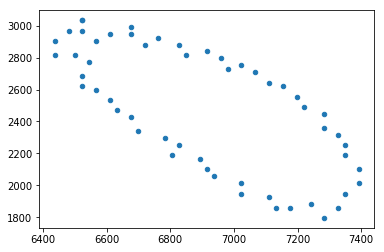

In [41]:
x_list = []
y_list = []
min_x = 9999999
min_y = 9999999
max_x = 0
max_y = 0


coor_list = str_contour[135]['IC'][0.5]
for x, y in coor_list:
    x_list.append(x)
    y_list.append(y)

plt.scatter(x_list, y_list, s=20)

# Need to: design function that fills in all points in between

# Neuroglancer code

In [6]:
#Replace: viewer = neuroglancer.Viewer()

#With: 
neuroglancer.set_server_bind_address('0.0.0.0')
viewer = neuroglancer.Viewer()
print(viewer)

ip_name = !hostname -I
print('http://' + ip_name[0].strip() + ':' + viewer.get_viewer_url().split(':')[2]) ##Remote URL


viewer # port 41989

http://yuncong-Precision-WorkStation-T7500:42571/v/693d61155d485838e4fb08bbf55ec6ffc2f456c8/
http://132.239.73.85 172.17.0.1:42571/v/693d61155d485838e4fb08bbf55ec6ffc2f456c8/


http://yuncong-Precision-WorkStation-T7500:42571/v/693d61155d485838e4fb08bbf55ec6ffc2f456c8/

In [9]:
with viewer.txn() as s:
    s.layers['image'] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres')
    #   s.layers['segmentation'] = neuroglancer.SegmentationLayer(source='precomputed://file://./pre_data/12N', selected_alpha=0.3)
#     s.layers['Structure'] = neuroglancer.SegmentationLayer(
#         source=neuroglancer.LocalVolume(
#         data=structure_volume,
#         voxel_size=[10000,10000,10000],
#         voxel_offset = [20,20,0]
#         )
# )

In [27]:
neuroglancer.stop()

# End Neuroglancer Code

In [ ]:
# wholeslice_to_brainstem = -from_padded_to_wholeslice, from_padded_to_brainstem

#from_padded_to_wholeslice
rostral_limit = 50
caudal_limit = 1188
dorsal_limit = 21
ventral_limit = 738

#from_padded_to_brainstem
rostral_limit = 521
caudal_limit = 1057
dorsal_limit = 128
ventral_limit = 465